## Data Science Projects for Business - Final Project
# Car Price Prediction Model
Eliott Vacher Detournière | Julius Walkenhorst

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df_train = pd.read_csv('train.csv')

In [3]:
# Lowecase the column names and replace spaces with underscores
df_train.columns = (
    df_train.columns
    .str.lower()
    .str.strip()
    .str.replace(".", "", regex=False)
    .str.replace(" ", "_")
)

df_train.drop(columns=['levy'], inplace=True)

In [4]:
# Separate categorical and continuous features

cont_features = [
    'prod_year',
    'engine_volume',
    'mileage',
    'airbags'
]

cat_features = [
    'manufacturer',
    'model',
    'prod_year',
    'category',
    'leather_interior',
    'fuel_type',
    'gear_box_type',
    'drive_wheels',
    'doors',
    'wheel',
    'color'
]

In [5]:
cat_features_plot = [
    'manufacturer',
    'prod_year',
    'category',
    'leather_interior',
    'fuel_type',
    'gear_box_type',
    'drive_wheels',
    'cylinders',
    'doors',
    'wheel',
    'color'
]
# for feature in cat_features_plot:
#     df[feature].value_counts().plot(kind='bar', title=f'Frequency for {feature}')
#     plt.xlabel(feature)
#     plt.ylabel('Frequency')
#     plt.minorticks_on()
#     plt.grid(which='both', axis='y', linestyle='--', linewidth=0.5)
#     plt.show()

## Data cleaning and preprocessing

In [6]:
# Preprocess the data

# manufacturer: lowercase and encode
df_train['manufacturer'] = df_train['manufacturer'].str.lower().astype('category').cat.codes

# model: lowercase and encode
df_train['model'] = df_train['model'].str.lower().astype('category').cat.codes

# category: drop rows with limousines and encode
# df = df[df['category'].str.lower() != 'limousine']
df_train['category'] = df_train['category'].astype('category').cat.codes

# leather_interior: encode
df_train['leather_interior'] = df_train['leather_interior'].astype('category').cat.codes

# fuel_type: encode
df_train['fuel_type'] = df_train['fuel_type'].astype('category').cat.codes

# engine_volume: extract "Turbo" flag as a categorical feature and convert volume to float
df_train['turbo'] = df_train['engine_volume'].astype(str).str.contains('Turbo', case=False, na=False).astype(int)
df_train['engine_volume'] = df_train['engine_volume'].astype(str).str.replace('Turbo', '', case=False, regex=False).astype(float)

# mileage: remove " km" and convert to float
df_train['mileage'] = df_train['mileage'].astype(str).str.replace(' km', '', regex=False).astype(float)

# cylinders: turn to int
df_train['cylinders'] = df_train['cylinders'].astype(int)

# gear_box_type: encode
df_train['gear_box_type'] = df_train['gear_box_type'].astype('category').cat.codes

# drive_wheels: encode
df_train['drive_wheels'] = df_train['drive_wheels'].astype('category').cat.codes
# doors: encode
df_train['doors'] = df_train['doors'].astype('category').cat.codes

# wheel: encode
df_train['wheel'] = df_train['wheel'].astype('category').cat.codes

# color: encode
df_train['color'] = df_train['color'].astype('category').cat.codes

# airbags: ensure it's int
df_train['airbags'] = df_train['airbags'].astype(int)

Number of outliers in mileage: 640
            mileage
8      3.980690e+05
29     4.205500e+05
39     3.827460e+05
65     7.198470e+05
90     4.338110e+05
...             ...
19163  4.895840e+05
19167  2.147484e+09
19194  7.600000e+05
19199  1.111111e+09
19222  7.359700e+05

[640 rows x 1 columns]


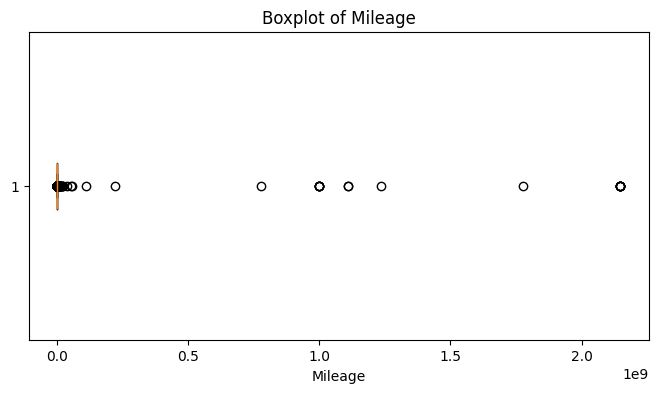

Shape of df after dropping mileage outliers: (18597, 18)


In [7]:
# Detect outliers in df['mileage'] using the IQR method

q1 = df_train['mileage'].quantile(0.25)
q3 = df_train['mileage'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers_mileage = df_train[(df_train['mileage'] < lower_bound) | (df_train['mileage'] > upper_bound)]
print("Number of outliers in mileage:", outliers_mileage.shape[0])
print(outliers_mileage[['mileage']])

# Optionally, visualize using a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(df_train['mileage'], vert=False)
plt.title("Boxplot of Mileage")
plt.xlabel("Mileage")
plt.show()

# Drop outliers
df_train = df_train[(df_train['mileage'] <= upper_bound)]
print("Shape of df after dropping mileage outliers:", df_train.shape)

In [8]:
outlier_price_index = df_train['price'].idxmax()
df_train.drop(index=outlier_price_index, inplace=True)

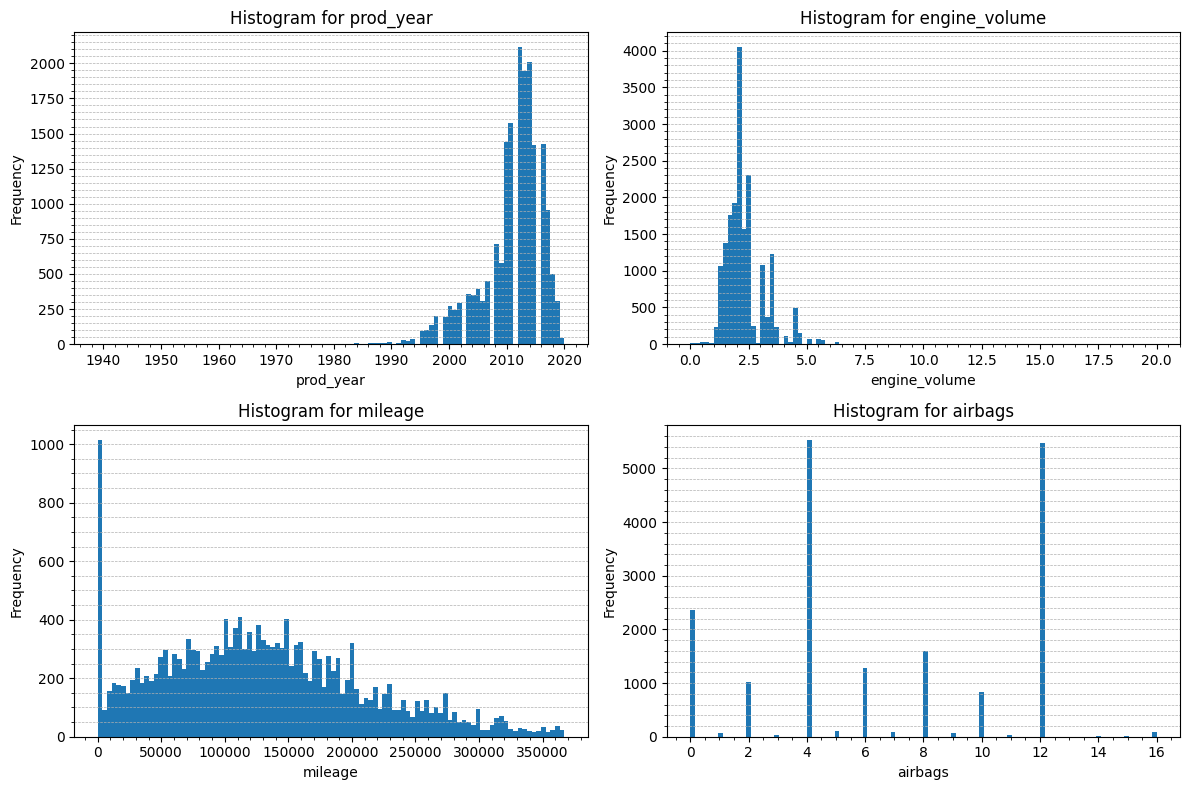

In [9]:
# Plot histograms for continuous features

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

for i, feature in enumerate(cont_features):
    axs[i].hist(df_train[feature], bins=100)
    axs[i].set_title(f'Histogram for {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')
    axs[i].minorticks_on()
    axs[i].grid(which='both', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Feature Importance

In [10]:
features = df_train.drop(columns=['price', 'id', 'wheel'])
target = df_train['price']

             feature  importance
6      engine_volume    0.223179
2          prod_year    0.207016
13           airbags    0.100490
7            mileage    0.092364
9      gear_box_type    0.063903
1              model    0.058265
5          fuel_type    0.047622
14             turbo    0.041146
0       manufacturer    0.034355
8          cylinders    0.033730
3           category    0.028359
12             color    0.024420
10      drive_wheels    0.021809
4   leather_interior    0.014796
11             doors    0.008548


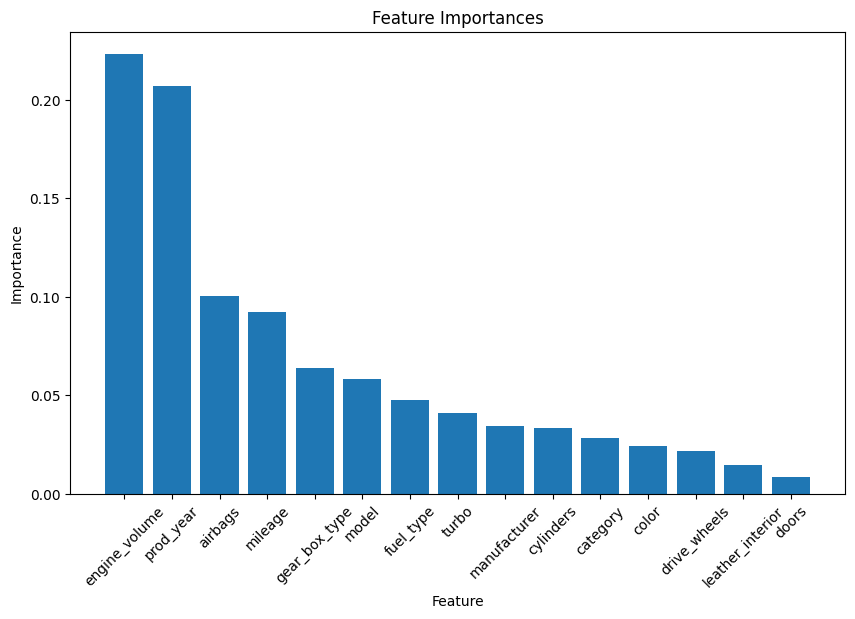

Model Performance Metrics:
Mean Absolute Error: 4700.895463153291
Mean Squared Error: 273354017.58552253
Root Mean Squared Error: 16533.42123051132
R^2 Score: 0.469769166257755


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data: use `features` as predictors and df_train['price'] as target
X = features
y = target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances and display as a dataframe
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(rotation=45)
plt.show()

# Compute model performance metrics
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Correlation matrix for continuous features:
               prod_year  engine_volume   mileage   airbags
prod_year       1.000000      -0.031119 -0.248741  0.239893
engine_volume  -0.031119       1.000000  0.177570  0.221430
mileage        -0.248741       0.177570  1.000000 -0.023171
airbags         0.239893       0.221430 -0.023171  1.000000


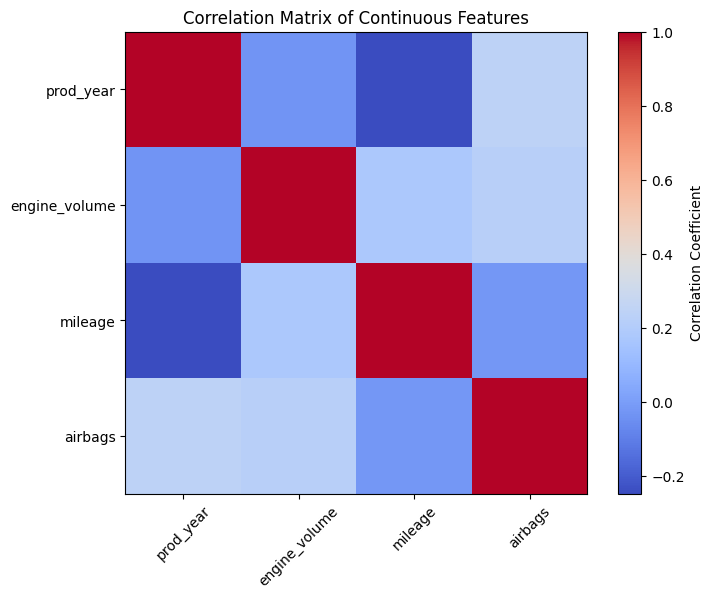

In [12]:
# Compute the correlation matrix for continuous features
corr_matrix = df_train[cont_features].corr()
print("Correlation matrix for continuous features:")
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(cont_features)), cont_features, rotation=45)
plt.yticks(range(len(cont_features)), cont_features)
plt.title('Correlation Matrix of Continuous Features')
plt.show()

## Model Development

In [13]:
print(df_train.columns)

Index(['id', 'price', 'manufacturer', 'model', 'prod_year', 'category',
       'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags', 'turbo'],
      dtype='object')


Linear Regression Model Performance:
Mean Squared Error (MSE): 422669904.94431716
Root Mean Squared Error (RMSE): 20558.937349588796
R^2 Score: 0.18013783709520925


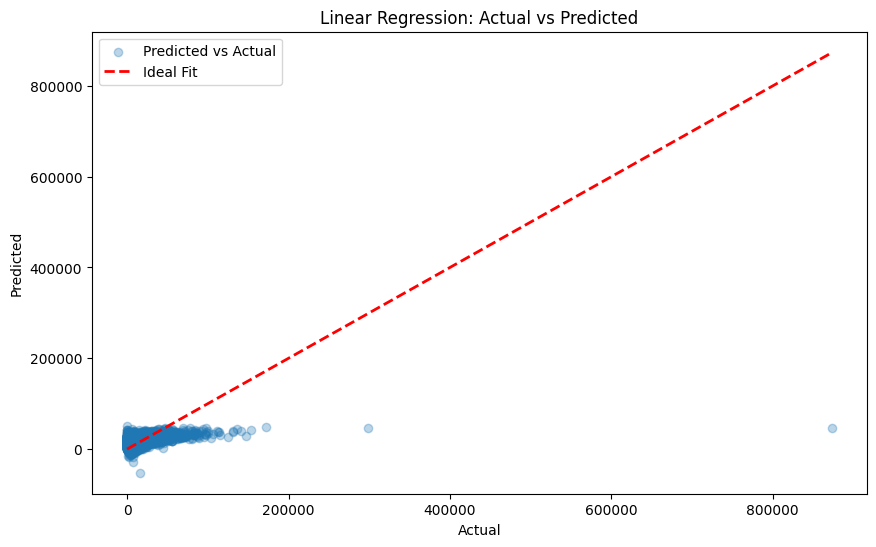

In [14]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Predict on the test data
y_pred_lr = lr.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mse_lr ** 0.5
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Model Performance:")
print("Mean Squared Error (MSE):", mse_lr)
print("Root Mean Squared Error (RMSE):", rmse_lr)
print("R^2 Score:", r2_lr)

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

The baseline model's performance struggles to capture the true relationship between actual and predicted values. The majority of predictions are clustered around the lower end of the spectrum, indicating that the model may not be handling larger values effectively. Ideally, the points should align closely with the red dashed line, which would represent perfect predictions. However, significant deviations, particularly for higher actual values, hint at potential underfitting or a high-bias issue.

One possible reason for this behavior is that the model may not be complex enough to capture the underlying patterns in the data. If it consistently underestimates or fails to predict higher values accurately, it could indicate that the chosen features are not sufficiently informative or that the data distribution is skewed. Additionally, analyzing residuals—differences between actual and predicted values—could reveal whether there are systematic errors or if certain parts of the dataset are being predicted worse than others.

## Machine Learning Models

In [18]:
print(df_train.columns)

Index(['id', 'price', 'manufacturer', 'model', 'prod_year', 'category',
       'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags', 'turbo'],
      dtype='object')


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [16]:
# Separate features and target
X = df_train.drop(columns=['price'])
y = df_train['price']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-Hot Encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
X_encoded.columns = encoder.get_feature_names_out(categorical_cols)

# Standardize numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_cols]), columns=numerical_cols)

# Concatenate processed numerical and categorical features
X_preprocessed = pd.concat([X_scaled, X_encoded], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


In [26]:
# Define base models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR()
}

In [28]:
# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append({"Model": name, "MSE": mse})

# Convert results to DataFrame and sort by MSE
results_df = pd.DataFrame(results).sort_values(by="MSE", ascending=True)

# Display results
print(results_df)  # Simple print statement


                      Model           MSE
6                   XGBoost  2.614487e+08
4             Random Forest  3.026160e+08
5         Gradient Boosting  3.319306e+08
0         Linear Regression  4.357622e+08
2          Lasso Regression  4.357624e+08
1          Ridge Regression  4.357625e+08
7  Support Vector Regressor  5.264086e+08
3             Decision Tree  6.017810e+08


The XGBoost model has the lowest Mean Squared Error (MSE) at 2,61*10^8, making it the best-performing model among your baselines. The Random Forest and Gradient Boosting models also perform well, while Linear Regression, Ridge, and Lasso Regression have significantly higher errors. The Decision Tree and Support Vector Regressor models perform the worst.

## XGBoost Optimization/Parameter Finetuning

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Define parameter grids
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0]
}

In [30]:
# Define models
models = {
    "XGBoost": (XGBRegressor(objective="reg:squarederror", random_state=42), param_grid_xgb),
    "Random Forest": (RandomForestRegressor(random_state=42), param_grid_rf),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=42), param_grid_gb),
}

# Perform Grid Search
best_models = {}
for name, (model, param_grid) in models.items():
    print(f"Optimizing {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")



Optimizing XGBoost...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Optimizing Random Forest...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Optimizing Gradient Boosting...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


In [31]:
# Evaluate best models
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append({"Model": name, "MSE": mse})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).sort_values(by="MSE", ascending=True)

# Display results
print(results_df)

               Model           MSE
0            XGBoost  2.626940e+08
1      Random Forest  2.844846e+08
2  Gradient Boosting  2.945437e+08


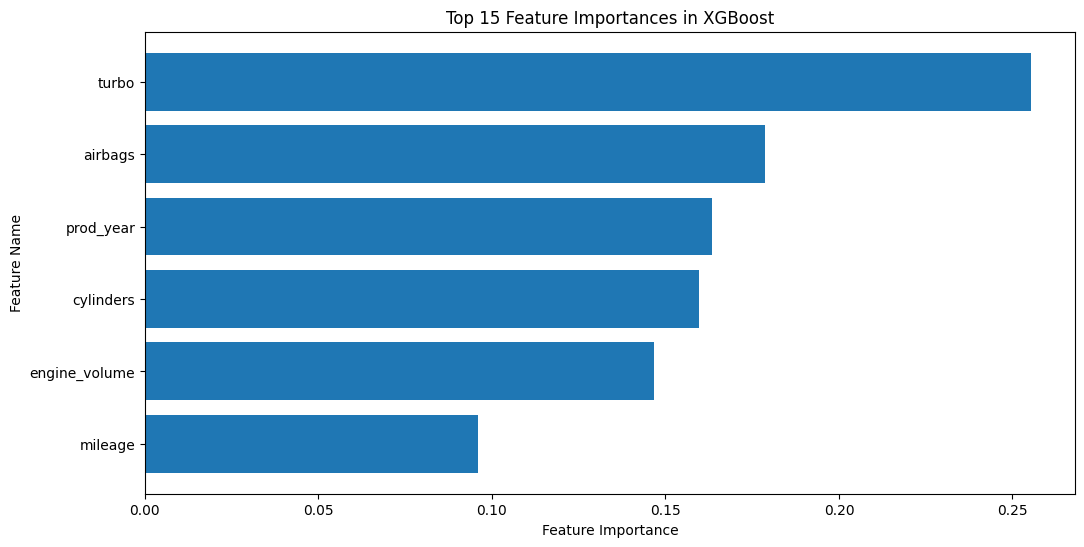

In [32]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance from the best XGBoost model
best_xgb = best_models["XGBoost"]
feature_importance = best_xgb.feature_importances_

# Create a DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': X_preprocessed.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feat_importance_df["Feature"][:15], feat_importance_df["Importance"][:15])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 15 Feature Importances in XGBoost")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [34]:
import optuna
from sklearn.model_selection import cross_val_score

# Define the objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.0001, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 0.0001, 1.0),
    }
    
    model = xgb.XGBRegressor(objective="reg:squarederror", **params, random_state=42)
    
    # Use cross-validation to evaluate performance
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
    
    return -scores.mean()  # Optuna minimizes, so we return negative MSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final XGBoost model with best params
best_xgb_optimized = xgb.XGBRegressor(objective="reg:squarederror", **best_params, random_state=42)
best_xgb_optimized.fit(X_train, y_train)

# Evaluate on test set
y_pred_optimized = best_xgb_optimized.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
print("Optimized XGBoost MSE:", mse_optimized)


[I 2025-02-28 13:48:16,861] A new study created in memory with name: no-name-308e7def-e6a2-4b2e-9479-09a3e6840e34
/var/folders/x3/pwfyssd506557jjyhrpj_2h40000gn/T/ipykernel_84734/2300963788.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/var/folders/x3/pwfyssd506557jjyhrpj_2h40000gn/T/ipykernel_84734/2300963788.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.0001, 1.0),
/var/folders/x3/pwfyssd506557jjyhrpj_2h40000gn/T/ipykernel_84734/2300963788.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be re

Best Hyperparameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.06762175736530582, 'subsample': 0.9290086765256544, 'colsample_bytree': 0.726341615990809, 'reg_alpha': 0.010083874504099734, 'reg_lambda': 0.10531224252119152}
Optimized XGBoost MSE: 246352384.0


In [35]:
import numpy as np

# Apply log transformation to target variable (if heavily skewed)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train new XGBoost with log-transformed target
best_xgb_optimized.fit(X_train, y_train_log)
y_pred_log = best_xgb_optimized.predict(X_test)

# Convert back to original scale
y_pred_original = np.expm1(y_pred_log)

# Compute MSE
mse_log = mean_squared_error(y_test, y_pred_original)
print("MSE after log transformation:", mse_log)


MSE after log transformation: 311255936.0


In [36]:
from sklearn.feature_selection import SelectFromModel

# Feature selection based on importance
selector = SelectFromModel(best_xgb_optimized, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Retrain model with selected features
best_xgb_optimized.fit(X_train_selected, y_train)
y_pred_selected = best_xgb_optimized.predict(X_test_selected)
mse_selected = mean_squared_error(y_test, y_pred_selected)

print("MSE after feature selection:", mse_selected)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


MSE after feature selection: 440068608.0


In [37]:
from sklearn.ensemble import StackingRegressor

stacked_model = StackingRegressor(
    estimators=[
        ('xgb', best_xgb_optimized),
        ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
    ],
    final_estimator=xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
)

stacked_model.fit(X_train, y_train)
y_pred_stacked = stacked_model.predict(X_test)
mse_stacked = mean_squared_error(y_test, y_pred_stacked)

print("MSE after stacking:", mse_stacked)


MSE after stacking: 297651552.0


In [40]:
best_params = {
    'n_estimators': 400,
    'max_depth': 6,
    'learning_rate': 0.06762175736530582,
    'subsample': 0.9290086765256544,
    'colsample_bytree': 0.726341615990809,
    'reg_alpha': 0.010083874504099734,
    'reg_lambda': 0.10531224252119152
}



In [45]:
import joblib
import xgboost as xgb

# Ensure it's an XGBRegressor, not a Booster
if isinstance(best_xgb_final, xgb.Booster):
    print("⚠️ Warning: Converting Booster to XGBRegressor")
    best_xgb_final = xgb.XGBRegressor()
    best_xgb_final.load_model("best_xgboost_model.json")  # Load the Booster into XGBRegressor

# Save with joblib (Pickle)
joblib.dump(best_xgb_final, "best_xgboost_model.pkl")

print("✅ Model saved successfully using joblib!")




✅ Model saved successfully using joblib!


## Gradient Boosting

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Sample Data
X = np.random.rand(100, 5)  # Features
y = np.random.rand(100) * 10000  # Target (continuous values)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Performance
mse = mean_squared_error(y_test, y_pred)
print(f"Gradient Boosting Regression MSE: {mse}")


Gradient Boosting Regression MSE: 11375740.465870623


In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}

grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [3]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}")


XGBoost MSE: 10189000.879716573


In [5]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import xgboost as xgb

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    xgb.XGBRegressor(), param_grid, scoring="neg_mean_squared_error", 
    cv=3, n_jobs=-1, return_train_score=True
)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Convert negative MSE to positive values
results_df["MSE"] = -results_df["mean_test_score"]

# Display all hyperparameter sets with their MSE
print("\nAll GridSearch Results (Sorted by MSE):")
print(results_df[["MSE", "params"]].sort_values(by="MSE"))

# Show the best parameters and corresponding MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print("\nBest Parameters Found:", best_params)
print(f"Best MSE: {best_mse:.4f}")




All GridSearch Results (Sorted by MSE):
             MSE                                             params
0   8.784183e+06  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
9   8.879753e+06  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...
18  8.896479e+06  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...
3   9.069049e+06  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
1   9.083675e+06  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
..           ...                                                ...
74  1.230871e+07  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...
53  1.260494e+07  {'learning_rate': 0.05, 'max_depth': 7, 'n_est...
50  1.261530e+07  {'learning_rate': 0.05, 'max_depth': 7, 'n_est...
47  1.269780e+07  {'learning_rate': 0.05, 'max_depth': 7, 'n_est...
26  1.270936e+07  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...

[81 rows x 2 columns]

Best Parameters Found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Best MSE: 8784182

In [ ]:
import joblib
import xgboost as xgb

# Use the best-found hyperparameters
best_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "max_depth": 3,
    "subsample": 0.6,
    "random_state": 42
}

# Train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Save the trained model as a .pkl file
joblib.dump(best_xgb_model, "best_xgboost_model1.pkl")

print("Model saved successfully as 'best_xgboost_model.pkl'!")


✅ Model saved successfully as 'best_xgboost_model.pkl'!


In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import joblib

# Define parameter grid for Gradient Boosting
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    GradientBoostingRegressor(), param_grid, scoring="neg_mean_squared_error", 
    cv=3, n_jobs=-1, return_train_score=True
)

# Fit the model
grid_search.fit(X_train, y_train)

# Extract results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Convert negative MSE to positive values
results_df["MSE"] = -results_df["mean_test_score"]

# Display all hyperparameter sets with their MSE
print("\n🔹 All GridSearch Results (Sorted by MSE):")
print(results_df[["MSE", "params"]].sort_values(by="MSE"))

# Show the best parameters and corresponding MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print("\nBest Parameters Found:", best_params)
print(f"Best MSE: {best_mse:.4f}")

# Train the model with the best parameters
best_gbr_model = GradientBoostingRegressor(**best_params)
best_gbr_model.fit(X_train, y_train)

# Save the trained model as a .pkl file
joblib.dump(best_gbr_model, "best_gradient_boosting_model.pkl")

print("Gradient Boosting Model saved successfully as 'best_gradient_boosting_model.pkl'!")



🔹 All GridSearch Results (Sorted by MSE):
             MSE                                             params
18  8.355663e+06  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...
9   8.880489e+06  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...
0   8.940563e+06  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
24  8.962891e+06  {'learning_rate': 0.01, 'max_depth': 7, 'n_est...
1   9.116439e+06  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
..           ...                                                ...
53  1.533660e+07  {'learning_rate': 0.05, 'max_depth': 7, 'n_est...
50  1.534187e+07  {'learning_rate': 0.05, 'max_depth': 7, 'n_est...
77  1.605720e+07  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...
80  1.614637e+07  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...
74  1.629784e+07  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...

[81 rows x 2 columns]

✅ Best Parameters Found: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
✅ Best MSE: 8

In [18]:
import joblib
from sklearn.ensemble import GradientBoostingRegressor

# Best parameters from Grid Search
best_params = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "max_depth": 7,
    "subsample": 0.6
}

# Train the best Gradient Boosting model
best_gbr_model = GradientBoostingRegressor(**best_params)
best_gbr_model.fit(X_train, y_train)

# Save the trained model as a .pkl file
joblib.dump(best_gbr_model, "best_gradient_boosting_model.pkl")

print("Best Gradient Boosting Model saved successfully as 'best_gradient_boosting_model.pkl'!")


✅ Best Gradient Boosting Model saved successfully as 'best_gradient_boosting_model.pkl'!
